# K. pneumoniae with MLP

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from utils import load_data, EvaluationResults

## Configs

In [2]:
# number of folds
# NOTE: there will be no true label in test data if you use too many folds
N_FOLDS = 5
# drug names
drugs = [
    'Ciprofloxacin',
    'Ceftriaxone',
    'Cefepime',
    'Meropenem',
    'Tobramycin',
]

## Helper function

In [3]:
def train_and_eval(X: np.ndarray, y: np.ndarray, use_smote=False) -> pd.DataFrame:
    results = {
        'AUROC': [],
        'Accuracy': [],
        'F1 Score': [],
    }

    # using params from <https://github.com/BorgwardtLab/maldi_amr>
    mlp = MLPClassifier(
        alpha=0.0001,
        activation='relu',
        random_state=164,
        hidden_layer_sizes=[512, 256, 128],
        max_iter=200,
        # verbose=1,
        # early_stopping=True,
        # n_iter_no_change=20,
        # validation_fraction=0.1,
    )

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)
    i = 0

    for train_index, test_index in skf.split(X, y):
        print(f'Fold {i}/{N_FOLDS}...')
        i += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if use_smote:
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)

        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        auc = roc_auc_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results['AUROC'].append(auc)
        results['Accuracy'].append(acc)
        results['F1 Score'].append(f1)
        print(f'AUC={auc}, ACC={acc}, f1={f1}')

    return pd.DataFrame(results)

## Training

In [4]:
base_results = {}
smote_results = {}

for d in drugs:
    print(f'Loading {d}...')
    X, y = load_data(
        pathogen='Klebsiella pneumoniae',
        drug=d,
        sites=['A'],
        years=[2015, 2016, 2017, 2018],
    )
    print('Training w/o SMOTE...')
    base_results[d] = train_and_eval(X, y, False)
    print('Training w/ SMOTE...')
    smote_results[d] = train_and_eval(X, y, True)

Loading Ciprofloxacin...
Training w/o SMOTE...
Fold 0/5...
AUC=0.7191712562286914, ACC=0.8811700182815356, f1=0.5517241379310345
Fold 1/5...
AUC=0.6076055599265671, ACC=0.8793418647166362, f1=0.3529411764705882
Fold 2/5...
AUC=0.6908339889850511, ACC=0.8756855575868373, f1=0.5072463768115942
Fold 3/5...
AUC=0.7381851560451088, ACC=0.8793418647166362, f1=0.5714285714285715
Fold 4/5...
AUC=0.7627240143369175, ACC=0.9084249084249084, f1=0.6428571428571428
Training w/ SMOTE...
Fold 0/5...
AUC=0.7188172043010753, ACC=0.8720292504570384, f1=0.5394736842105263
Fold 1/5...
AUC=0.7044715447154472, ACC=0.8647166361974405, f1=0.5131578947368421
Fold 2/5...
AUC=0.6965774980330448, ACC=0.8683729433272395, f1=0.5068493150684932
Fold 3/5...
AUC=0.6847364280094413, ACC=0.8738574040219378, f1=0.49635036496350365
Fold 4/5...
AUC=0.7138590203106332, ACC=0.8772893772893773, f1=0.5379310344827586
Loading Ceftriaxone...
Training w/o SMOTE...
Fold 0/5...
AUC=0.741939714789908, ACC=0.9138840070298769, f1=0.63

## Results Collection and Visualization

In [5]:
results = EvaluationResults(base_results, smote_results)
# export results to csv files
results.save_to('./results/kpn_mlp/')

### Bar Graph

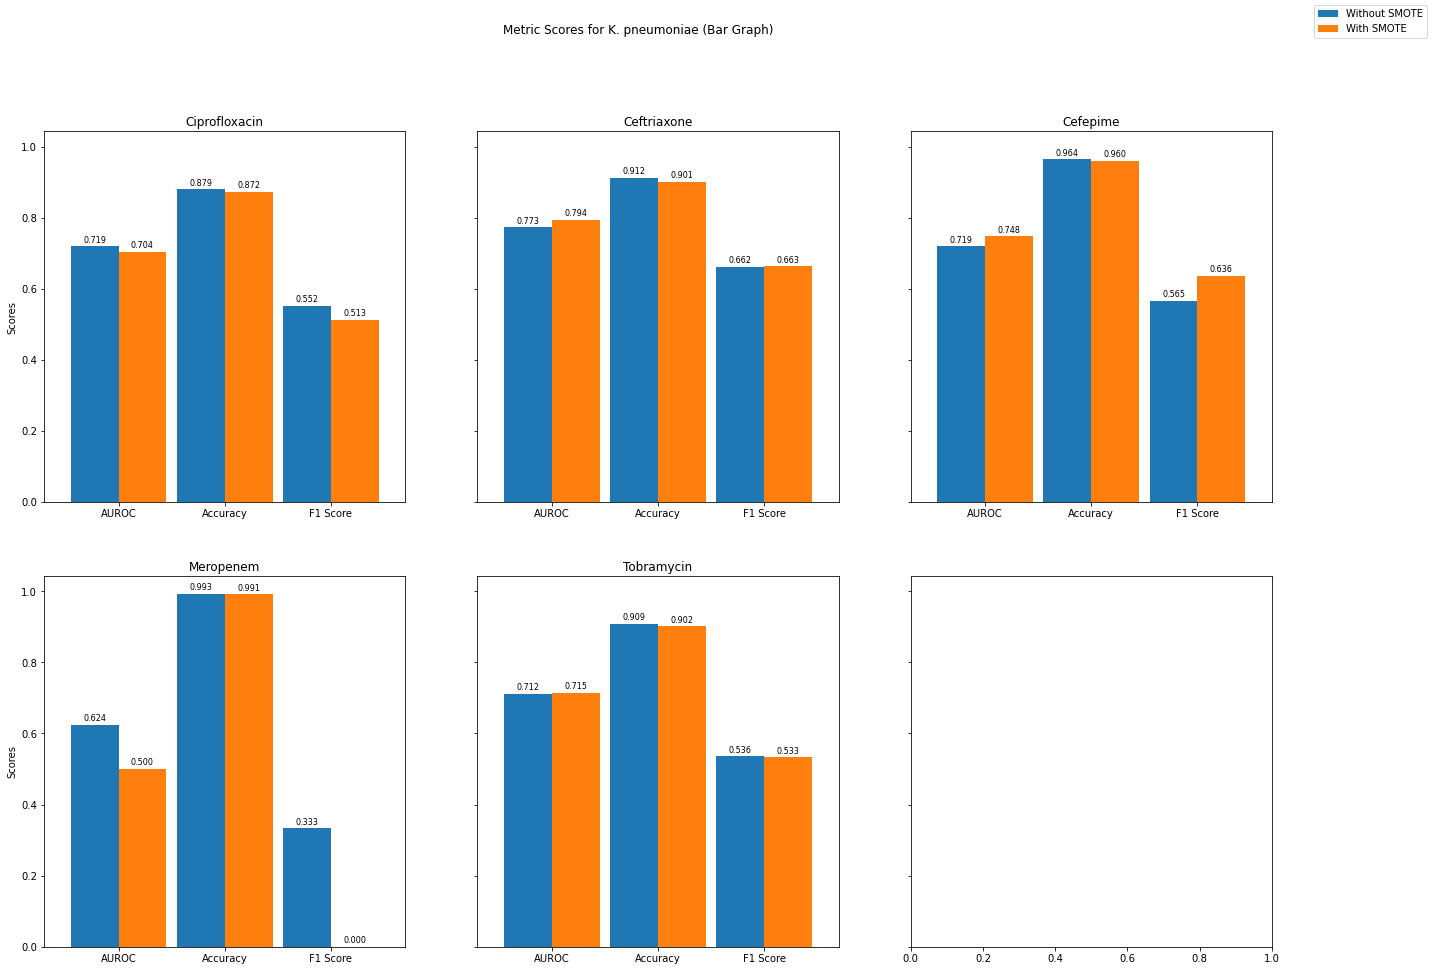

In [6]:
results.bar_plot(
    title='Metric Scores for K. pneumoniae (Bar Graph)',
    save_as='./results/kpn_mlp/bar.png',
    nrows=2,
    ncols=3,
    sharey=True,
    figsize=(22, 15),
)

### Box Graph

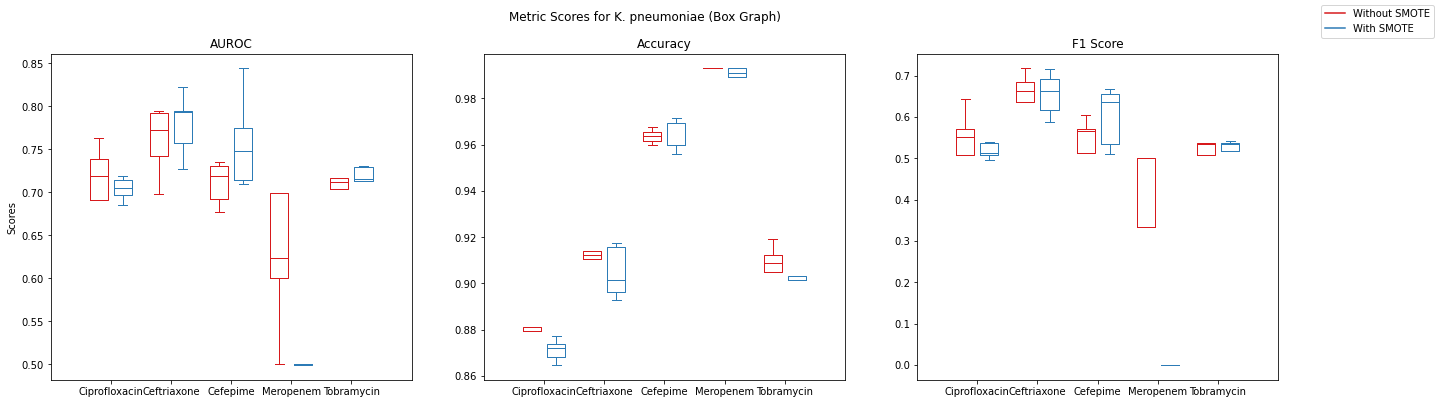

In [7]:
results.box_plot(
    title='Metric Scores for K. pneumoniae (Box Graph)',
    save_as='./results/kpn_mlp/box.png',
    nrows=1,
    ncols=3,
    # sharey=True,
    figsize=(22, 6),
)
